In [3]:
import polars as pl
from plotnine import *

In [4]:
# cat shotgun_sra_20231208/* |jq -r '[.acc,.releasedate,.mbases,.organism] |@csv' |pigz >sra_metadata/sra_metadata_20230915.some_columns.csv.gz
# df = pl.read_csv('sra_metadata/sra_metadata_20240110.some_columns.csv.gz', has_header=False)
df = pl.read_csv('sra_metadata/sra_metadata_20250220.some_columns.csv.gz', has_header=False)
df.columns = ['acc','releasedate','mbases','mbytes']
df[:4]

FileNotFoundError: No such file or directory (os error 2): sra_metadata/sra_metadata_20250220.some_columns.csv.gz

In [ ]:
df = df.with_columns(pl.col('releasedate').str.slice(0,10).str.to_date("%Y-%m-%d"))
df[:4]

acc,releasedate,mbases,mbytes
str,date,i64,i64
"""SRR15442735""",2021-08-13,6638,2614
"""ERR1959224""",2017-07-08,8555,3195
"""ERR5003368""",2020-12-23,1013,344
"""ERR5261058""",2021-03-15,20619,6792


In [ ]:
sum(df['mbases']) / 1_000_000 #=> This many terabases

4866.907013

In [ ]:
len(df) # => This many runs

783205

In [ ]:
df = df.with_columns(pl.date(year=pl.col('releasedate').dt.year(), month=pl.col('releasedate').dt.month(), day=1))
df[:4]
# per_month = df.groupby('releasedate').agg(pl.sum('mbases').alias('mbases'))

acc,releasedate,mbases,mbytes,date
str,date,i64,i64,date
"""SRR15442735""",2021-08-13,6638,2614,2021-08-01
"""ERR1959224""",2017-07-08,8555,3195,2017-07-01
"""ERR5003368""",2020-12-23,1013,344,2020-12-01
"""ERR5261058""",2021-03-15,20619,6792,2021-03-01


In [ ]:
per_month = df.group_by('date').agg(pl.sum('mbases').alias('Gbp') / 1_000)
per_month[:4]

date,Gbp
date,f64
2014-08-01,222.171
2016-09-01,3135.121
2014-12-01,982.034
2024-08-01,108670.722


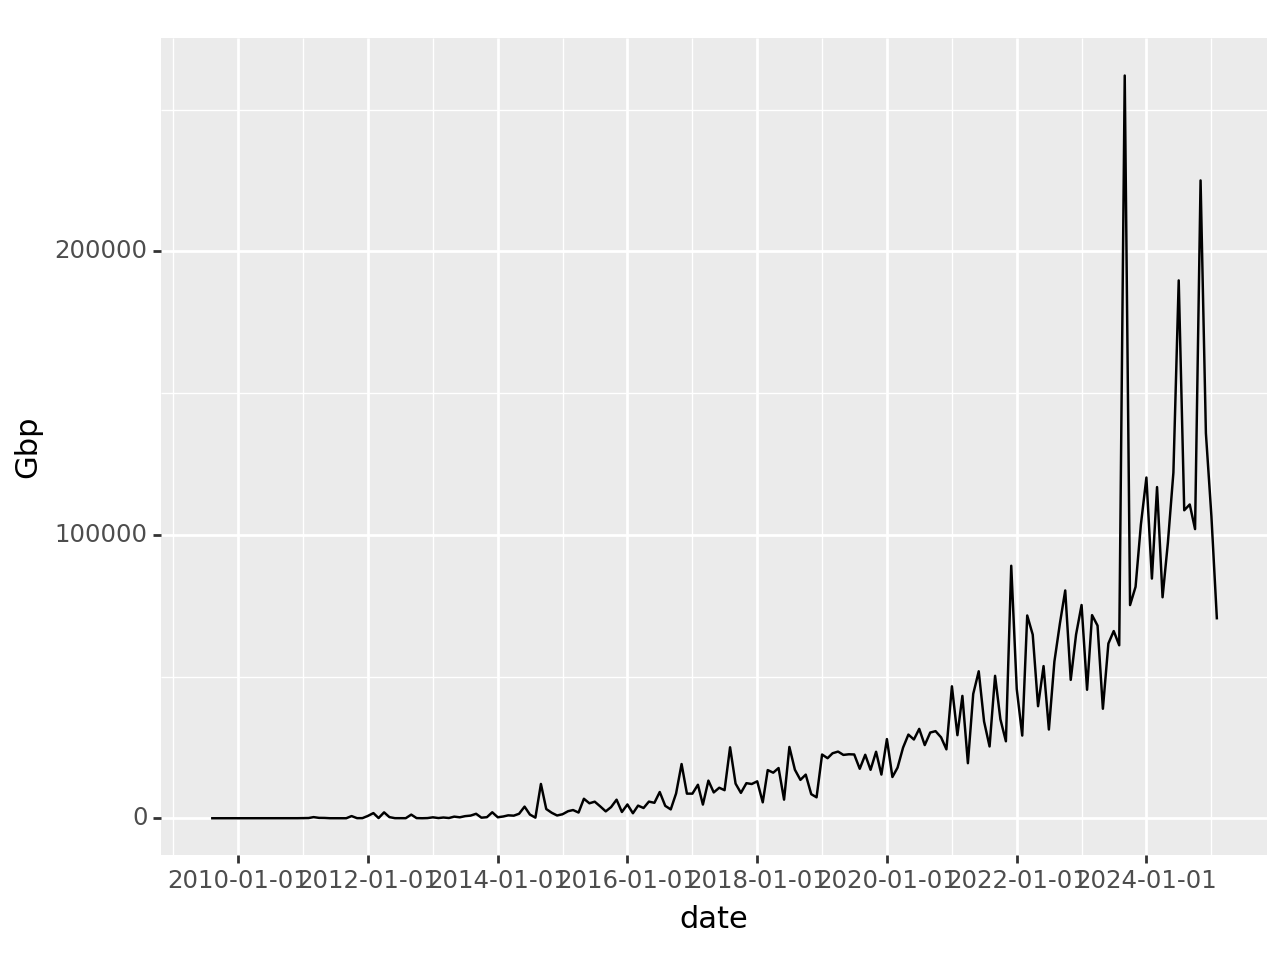

<Figure Size: (640 x 480)>

In [ ]:
ggplot(per_month, aes(x='date', y='Gbp'))+geom_line() #+geom_smooth(colour='blue')

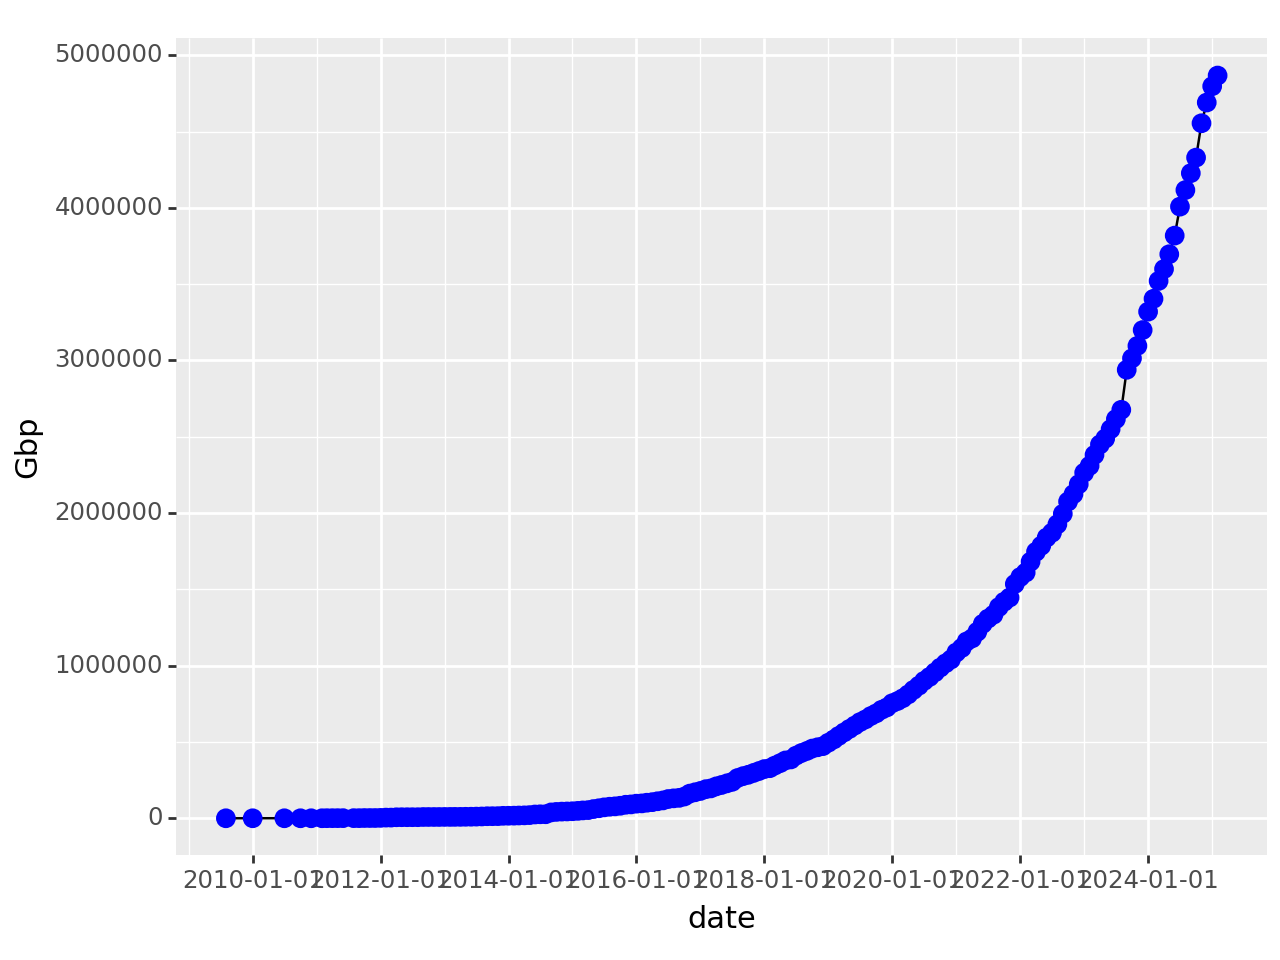

<Figure Size: (640 x 480)>

In [ ]:
perm_month_cumulative = per_month.sort('date').with_columns(pl.col('Gbp').cum_sum())
ggplot(perm_month_cumulative, aes(x='date', y='Gbp'))+geom_line()+geom_point(size=3, colour='blue') #+geom_smooth(colour='blue')

/home/ben/e/mybase/lib/python3.11/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



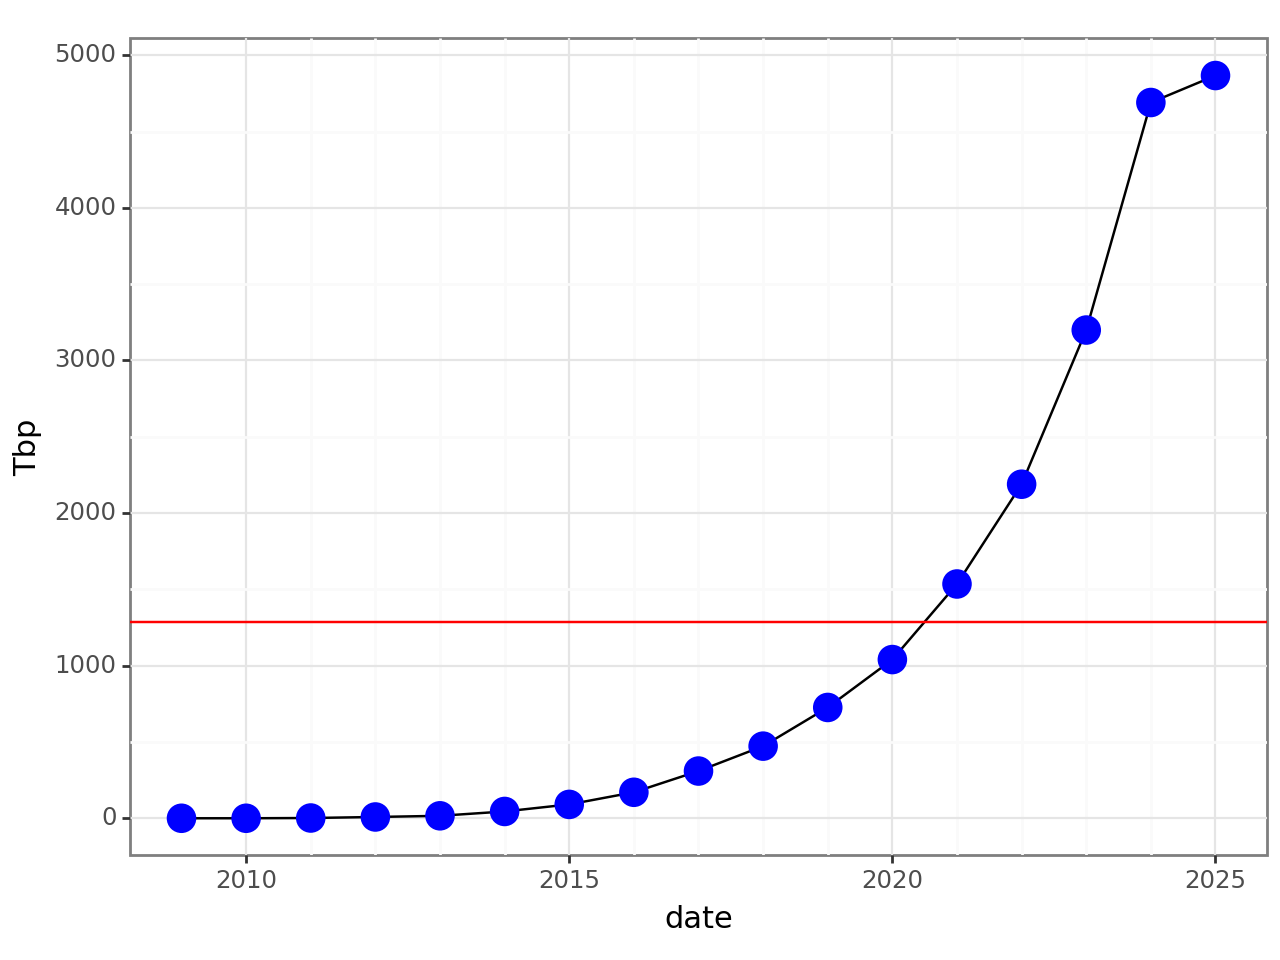

<Figure Size: (640 x 480)>

In [ ]:
per_year = df.with_columns(pl.col('releasedate').dt.year().alias('date')).group_by('date').agg(pl.sum('mbases').alias('Gbp') / 1_000)
perm_year_cumulative = per_year.sort('date').with_columns(pl.col('Gbp').cum_sum())
perm_year_cumulative = perm_year_cumulative.with_columns((pl.col('Gbp') / 1000).alias('Tbp'))
ggplot(perm_year_cumulative, xlab='', aes(x='date', y='Tbp'))+geom_line()+geom_point(size=5, colour='blue')+xlim([2012,max(per_year['date'])])+theme_bw()+geom_hline(yintercept=1287,colour='red')+scale_x_continuous(
    breaks=range(2010,max(per_year['date'])+1,5),
    minor_breaks=range(2010,max(per_year['date'])+1,1))

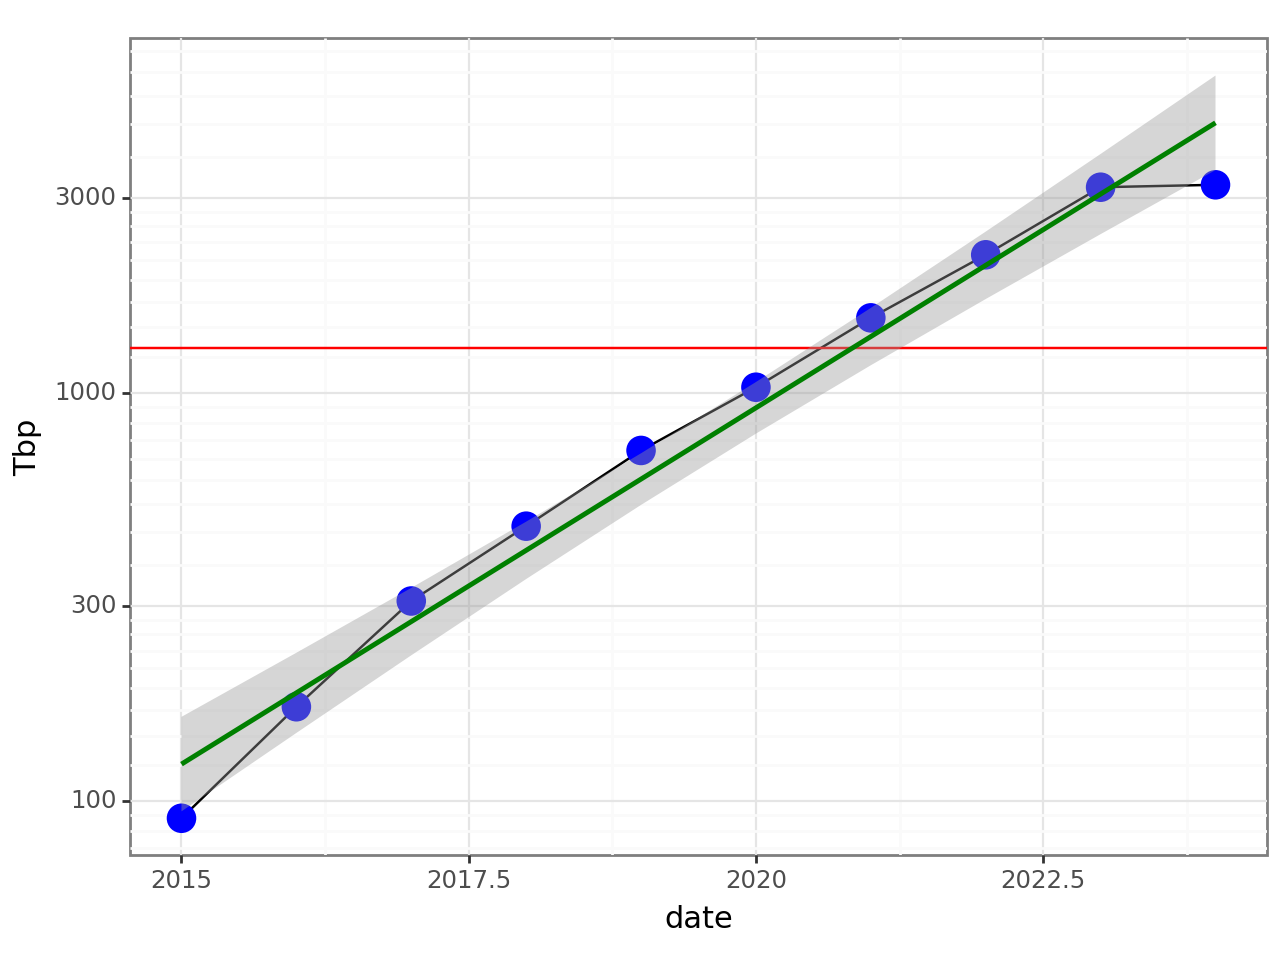

<Figure Size: (640 x 480)>

In [ ]:
per_year = df.with_columns(pl.col('releasedate').dt.year().alias('date')).groupby('date').agg(pl.sum('mbases').alias('Gbp') / 1_000)
perm_year_cumulative = per_year.sort('date').with_columns(pl.col('Gbp').cumsum())
perm_year_cumulative = perm_year_cumulative.with_columns((pl.col('Gbp') / 1000).alias('Tbp'))
ggplot(perm_year_cumulative.filter(pl.col('date')>2014), aes(x='date', y='Tbp'))+geom_line()+geom_point(size=5, colour='blue')+theme_bw()+geom_hline(yintercept=1287,colour='red')+scale_x_continuous(
    # breaks=range(2010,max(per_year['date'])+1,5),
    # minor_breaks=range(2010,max(per_year['date'])+1,1)
    )+scale_y_log10()+geom_smooth(method='lm', colour='green')

/home/ben/e/mybase/lib/python3.11/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



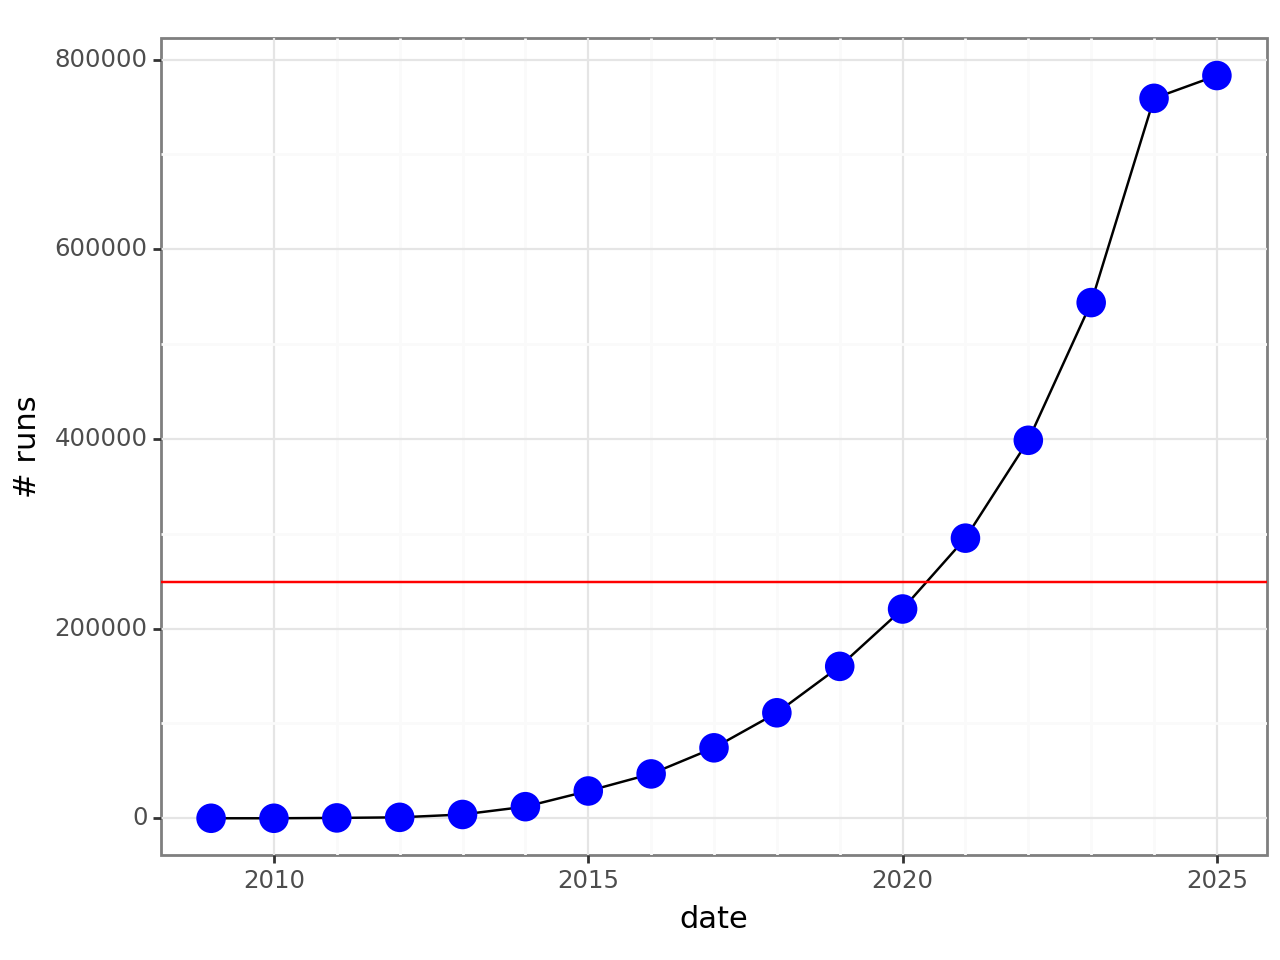

<Figure Size: (640 x 480)>

In [ ]:
# and number of runs
per_year = df.with_columns(pl.col('releasedate').dt.year().alias('date')).group_by('date').len()
perm_year_cumulative = per_year.sort('date').with_columns(pl.col('len').alias('# runs').cum_sum())
# perm_year_cumulative = perm_year_cumulative.with_columns((pl.col('# runs') / 1000).alias('Tbp'))
ggplot(perm_year_cumulative, aes(x='date', y='# runs'))+geom_line()+geom_point(size=5, colour='blue')+xlim([2012,max(per_year['date'])])+theme_bw()+geom_hline(yintercept=248905,colour='red')+scale_x_continuous(
    breaks=range(2010,max(per_year['date'])+1,5),
    minor_breaks=range(2010,max(per_year['date'])+1,1))